# **Setup and Imports**

In [1]:
import ast
import io
import tokenize
import keyword
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Code Snippets for analysis

In [29]:
# Objective: Prepare a minimum of 10 code snippets.
code_snippets = [
    "def add(a, b):\n    return a + b",
    "class Dog:\n    def __init__(self, name):\n        self.name = name",
    "squares = [x*x for x in range(10)]",
    "with open('file.txt', 'w') as f:\n    f.write('Hello NLP')",
    "from collections import Counter \nimport pandas as pd\ndf = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})",
    "def find_max(numbers):\n    max_val = numbers[0]\n    for num in numbers:\n        if num > max_val:\n            max_val = num\n    return max_val",
    "class Greeter:\n    def say_hello(self, person_name):\n        print(f'Hello, {person_name}!')",
    "for i in range(5):\n    print(i)",
    "try:\n    result = 10 / 0\nexcept ZeroDivisionError:\n    print('Cannot divide by zero!')",
    "def is_even(number):\n    return number % 2 == 0",

    "def factorial(n):\n    return 1 if n<=1 else n*factorial(n-1)",
    "def fib(n):\n    a,b=0,1\n    for _ in range(n):\n        a,b=b,a+b\n    return a",
    "class Person:\n    age = 0",
    "import os\nfiles = os.listdir('.')",
    "def safe_div(a,b):\n    try:\n        return a/b\n    except ZeroDivisionError:\n        return None",
    "[x for x in range(5) if x%2==0]",
    "async def foo():\n    return 42",

]

# Parse AST

In [30]:
def extract_ast_features(code):
  tree = ast.parse(code)
  features = {
      'functions':[],
      'classes': [],
      'imports':[],
      'patterns':[]
  }
  for node in ast.walk(tree):
    if isinstance(node, ast.FunctionDef):
      features['functions'].append(node.name)
    elif isinstance(node, ast.ClassDef):
      features['classes'].append(node.name)
    elif isinstance(node, ast.Import):
            features["imports"].extend([alias.name for alias in node.names])
    elif isinstance(node, ast.ImportFrom):
        features["imports"].extend([alias.name for alias in node.names])
    if isinstance(node, ast.Try):
        if "Exception Handling" not in features["patterns"]:
            features["patterns"].append("Exception Handling")
    if isinstance(node, ast.With):
        if "With Statement" not in features["patterns"]:
            features["patterns"].append("With Statement")
    if isinstance(node, ast.For):
      if "For Loop" not in features["patterns"]:
          features["patterns"].append("For Loop")
    if isinstance(node, ast.ListComp):
        if "List comp" not in features["patterns"]:
          features['patterns'].append("List comp")
    if isinstance(node, ast.GeneratorExp):
        if "Generator" not in features["patterns"]:
            features["patterns"].append("Generator")
    if isinstance(node, ast.DictComp):
        if "Dict comp" not in features["patterns"]:
            features["patterns"].append("Dict comp")
    if isinstance(node, ast.While):
        if "While Loop" not in features["patterns"]:
            features["patterns"].append("While Loop")
    if isinstance(node, ast.Try):
        if "Exception Handling" not in features["patterns"]:
            features["patterns"].append("Exception Handling")
    if isinstance(node, ast.Yield):
        if "Generator" not in features["patterns"]:
            features["patterns"].append("Generator")

  return features

In [31]:
extract_ast_features(code_snippets[3])

{'functions': [], 'classes': [], 'imports': [], 'patterns': ['With Statement']}

# Tokenization

In [32]:
def tokenize_code(code):
  tokens = []
  try:
    generator = tokenize.generate_tokens(io.StringIO(code).readline)
    for token in generator:
      if token.type not in {tokenize.COMMENT, tokenize.NL, tokenize.NEWLINE, tokenize.INDENT, tokenize.DEDENT, tokenize.ENDMARKER}:
        tokens.append(token.string)
  except tokenize.TokenError:
    return ['parsing error']
  return tokens

In [33]:
tokenize_code(code_snippets[3])

['with',
 'open',
 '(',
 "'file.txt'",
 ',',
 "'w'",
 ')',
 'as',
 'f',
 ':',
 'f',
 '.',
 'write',
 '(',
 "'Hello NLP'",
 ')']

In [34]:
processed_data = []
for i, snippet in enumerate(code_snippets):
    ast_features = extract_ast_features(snippet)
    tokens = tokenize_code(snippet)
    processed_data.append({
        "id": f"Snippet {i+1}",
        "code": snippet,
        "features": ast_features,
        "tokens": tokens
    })

In [35]:
df_processed = pd.DataFrame(processed_data)

In [36]:
df_processed

,id,code,features,tokens
0,Snippet 1,"def add(a, b):\n return a + b","{'functions': ['add'], 'classes': [], 'imports...","[def, add, (, a, ,, b, ), :, return, a, +, b]"
1,Snippet 2,"class Dog:\n def __init__(self, name):\n ...","{'functions': ['__init__'], 'classes': ['Dog']...","[class, Dog, :, def, __init__, (, self, ,, nam..."
2,Snippet 3,squares = [x*x for x in range(10)],"{'functions': [], 'classes': [], 'imports': []...","[squares, =, [, x, *, x, for, x, in, range, (,..."
3,Snippet 4,"with open('file.txt', 'w') as f:\n f.write(...","{'functions': [], 'classes': [], 'imports': []...","[with, open, (, 'file.txt', ,, 'w', ), as, f, ..."
4,Snippet 5,from collections import Counter \nimport panda...,"{'functions': [], 'classes': [], 'imports': ['...","[from, collections, import, Counter, import, p..."
5,Snippet 6,def find_max(numbers):\n max_val = numbers[...,"{'functions': ['find_max'], 'classes': [], 'im...","[def, find_max, (, numbers, ), :, max_val, =, ..."
6,Snippet 7,"class Greeter:\n def say_hello(self, person...","{'functions': ['say_hello'], 'classes': ['Gree...","[class, Greeter, :, def, say_hello, (, self, ,..."
7,Snippet 8,for i in range(5):\n print(i),"{'functions': [], 'classes': [], 'imports': []...","[for, i, in, range, (, 5, ), :, print, (, i, )]"
8,Snippet 9,try:\n result = 10 / 0\nexcept ZeroDivision...,"{'functions': [], 'classes': [], 'imports': []...","[try, :, result, =, 10, /, 0, except, ZeroDivi..."
9,Snippet 10,def is_even(number):\n return number % 2 == 0,"{'functions': ['is_even'], 'classes': [], 'imp...","[def, is_even, (, number, ), :, return, number..."


In [37]:
for index, row in df_processed.iterrows():
    print(f"{row['id']}: {row['features']}")

Snippet 1: {'functions': ['add'], 'classes': [], 'imports': [], 'patterns': []}
Snippet 2: {'functions': ['__init__'], 'classes': ['Dog'], 'imports': [], 'patterns': []}
Snippet 3: {'functions': [], 'classes': [], 'imports': [], 'patterns': ['List comp']}
Snippet 4: {'functions': [], 'classes': [], 'imports': [], 'patterns': ['With Statement']}
Snippet 5: {'functions': [], 'classes': [], 'imports': ['Counter', 'pandas'], 'patterns': []}
Snippet 6: {'functions': ['find_max'], 'classes': [], 'imports': [], 'patterns': ['For Loop']}
Snippet 7: {'functions': ['say_hello'], 'classes': ['Greeter'], 'imports': [], 'patterns': []}
Snippet 8: {'functions': [], 'classes': [], 'imports': [], 'patterns': ['For Loop']}
Snippet 9: {'functions': [], 'classes': [], 'imports': [], 'patterns': ['Exception Handling']}
Snippet 10: {'functions': ['is_even'], 'classes': [], 'imports': [], 'patterns': []}
Snippet 11: {'functions': ['factorial'], 'classes': [], 'imports': [], 'patterns': []}
Snippet 12: {'fun

# Embedding generation with models

In [38]:
model_names = {
    "MiniLM": "all-MiniLM-L6-v2",
    "DistilRoBERTa": "all-distilroberta-v1", # Removed due to error
    "MPNet": "all-mpnet-base-v2"
}
models = {}
embeddings = {}

print("\n--- Loading Models and Generating Embeddings ---")
for name, path in model_names.items():
    print(f"Loading {name} model...")
    models[name] = SentenceTransformer(path, trust_remote_code=True)
    print(f"Generating embeddings with {name}...")
    embeddings[name] = models[name].encode(df_processed['code'].tolist())
    print(f"[✓] Embeddings generated for {name}.")


--- Loading Models and Generating Embeddings ---
Loading MiniLM model...
Generating embeddings with MiniLM...
[✓] Embeddings generated for MiniLM.
Loading DistilRoBERTa model...
Generating embeddings with DistilRoBERTa...
[✓] Embeddings generated for DistilRoBERTa.
Loading MPNet model...
Generating embeddings with MPNet...
[✓] Embeddings generated for MPNet.


In [39]:
embeddings

{'MiniLM': array([[-0.02378805, -0.00600838, -0.06712577, ..., -0.02051951,
          0.02840974, -0.04567709],
        [-0.08832707,  0.03102673, -0.01338003, ...,  0.03281898,
          0.08499143,  0.05726318],
        [ 0.03963087,  0.09130798, -0.02002821, ...,  0.09889407,
          0.07044128,  0.01337309],
        ...,
        [-0.02443926,  0.0598356 , -0.04708898, ...,  0.08877373,
          0.04014811,  0.00613955],
        [ 0.07851807,  0.06301776,  0.01797112, ...,  0.09219765,
          0.04582513, -0.03477053],
        [-0.05142858, -0.0167279 , -0.05881964, ...,  0.00388967,
          0.05060946,  0.0142277 ]], dtype=float32),
 'DistilRoBERTa': array([[ 0.04318225,  0.06108587, -0.01138536, ...,  0.02896875,
         -0.02966308, -0.04104172],
        [-0.02196016,  0.03889177,  0.00035915, ..., -0.00572229,
         -0.00842929,  0.01764739],
        [-0.01785518, -0.00880776, -0.01353844, ...,  0.01478164,
          0.0030318 , -0.04189512],
        ...,
        [-0.

# Model Comparison

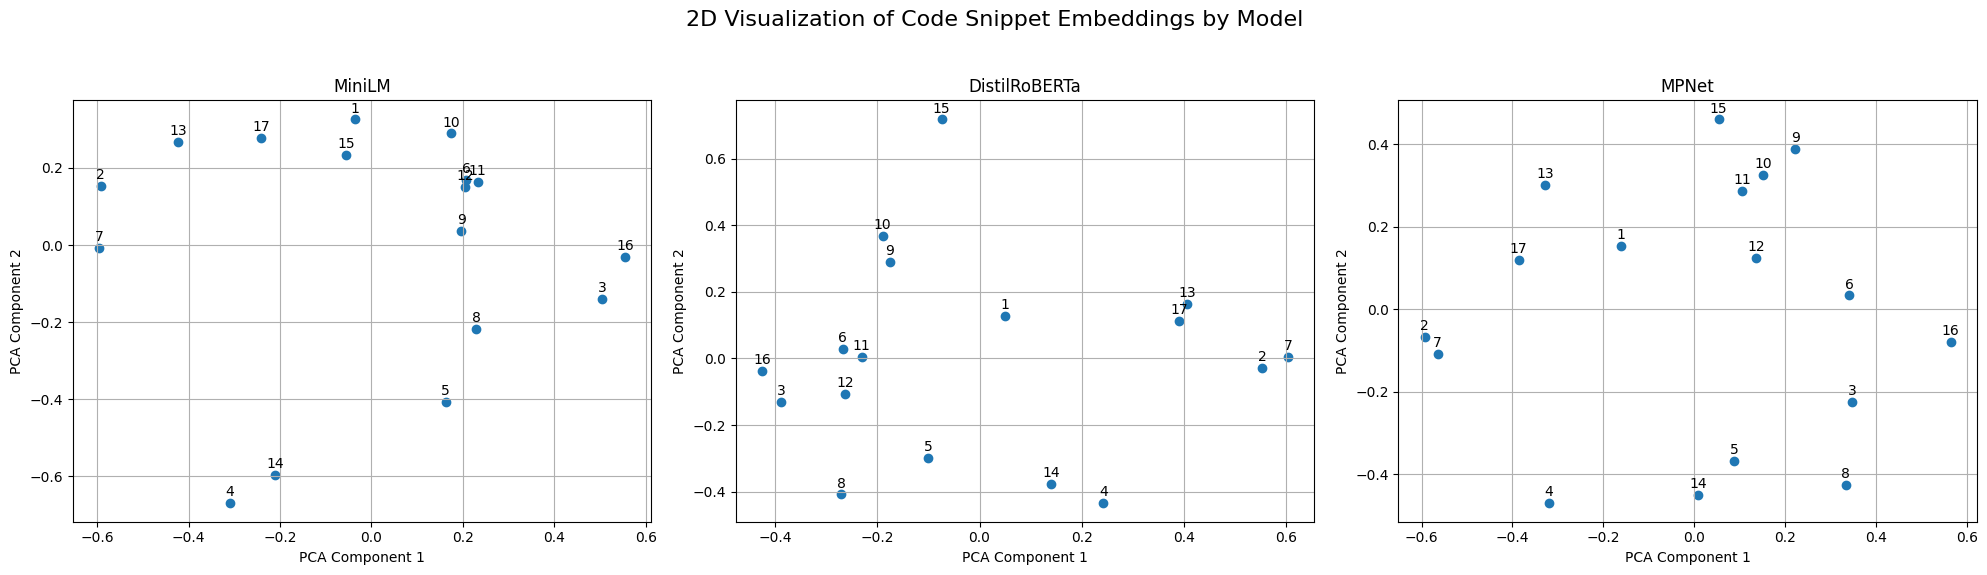

In [40]:
pca = PCA(n_components=2)
fig, axes = plt.subplots(1, len(models), figsize=(20, 6))
fig.suptitle('2D Visualization of Code Snippet Embeddings by Model', fontsize=16)

for i, (name, embs) in enumerate(embeddings.items()):
    embeddings_2d = pca.fit_transform(embs)
    ax = axes[i]
    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for j, row in enumerate(embeddings_2d):
        ax.annotate(f"{j+1}", (row[0], row[1]), textcoords="offset points", xytext=(0,5), ha='center')
    ax.set_title(name)
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [41]:
print("\n--- Visualization Analysis ---")
print("The plots show how each model clusters the code snippets based on semantic meaning.")
print("Now, consider how the presence of specific 'patterns' might influence these clusters.")
print("For example, does a model group Snippet 3 (List Comp) and Snippet 8 (For Loop) together because they are both iterative?")



--- Visualization Analysis ---
The plots show how each model clusters the code snippets based on semantic meaning.
Now, consider how the presence of specific 'patterns' might influence these clusters.
For example, does a model group Snippet 3 (List Comp) and Snippet 8 (For Loop) together because they are both iterative?


Heatmaps

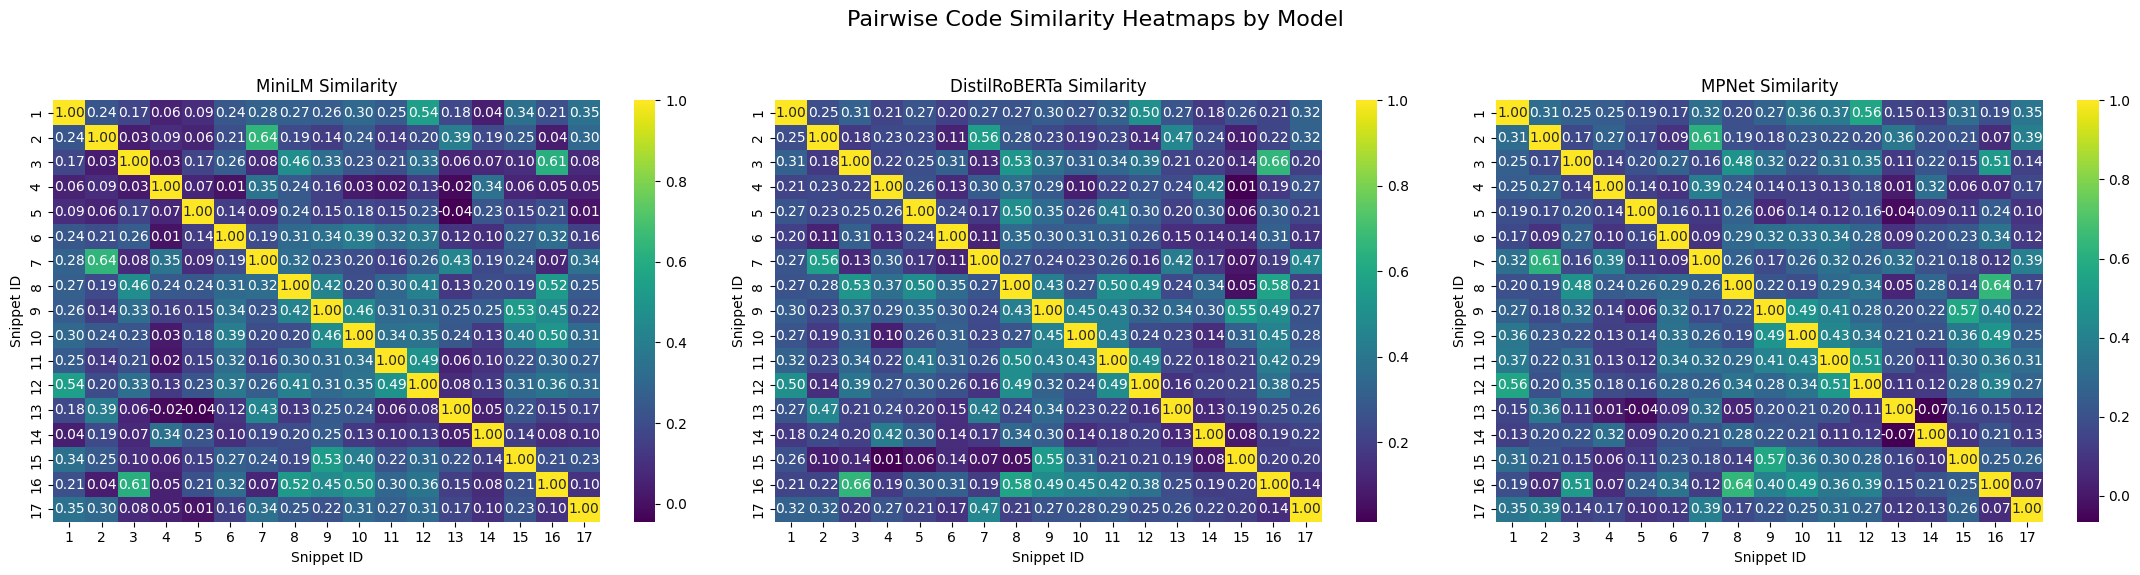

In [42]:


fig_heatmap, axes_heatmap = plt.subplots(1, len(models), figsize=(22, 6))
fig_heatmap.suptitle('Pairwise Code Similarity Heatmaps by Model', fontsize=16)
snippet_labels = [f"{i+1}" for i in range(len(code_snippets))]

for i, (name, embs) in enumerate(embeddings.items()):
    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(embs)

    # Plot heatmap
    ax = axes_heatmap[i]
    sns.heatmap(similarity_matrix, ax=ax, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=snippet_labels, yticklabels=snippet_labels)
    ax.set_title(f"{name} Similarity")
    ax.set_xlabel("Snippet ID")
    ax.set_ylabel("Snippet ID")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()